# 금융해커톤_v1 (Google Colab)

> "소비 패턴이 건전한지 위험한지"를 규칙 기반 점수에 맞춰 예측하는 Synthetic 금융 건강도 모델

# 0) 설치


In [ ]:
!pip -q install numpy pandas scikit-learn lightgbm shap imbalanced-learn --upgrade

import warnings, os, zipfile, glob, re
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 125.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [ ]:
# Download Kaggle dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kartik2112/fraud-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fraud-detection


In [ ]:
# === 0) 파일 위치 (업로드 경로에 맞게 유지) ===
SEARCH_DIRS = [
    "/content/data/가계재무데이터_v0"
]

# === 1) 유틸: 파일 로드 (EUC-KR 우선, 실패시 UTF-8) ===
def read_csv_safely(path):
    enc_tried = []
    for enc in ["euc-kr", "utf-8"]:
        try:
            df = pd.read_csv(path, encoding=enc)
            return df, enc
        except UnicodeDecodeError:
            enc_tried.append(enc)
            continue
    # 마지막 시도: engine='python' (구분자 변동 대비)
    for enc in ["euc-kr", "utf-8"]:
        try:
            df = pd.read_csv(path, encoding=enc, engine="python")
            return df, enc + " (python)"
        except Exception:
            continue
    raise ValueError(f"인코딩 실패: {path} (tried {enc_tried})")

# === 2) 유틸: 컬럼/문자 정리 ===
def clean_text(s):
    if pd.isna(s): return s
    s = str(s)
    return (s.replace("\u00a0","")  # NBSP
            .replace("−", "-")      # 음수기호 통일
            .strip())

def std_whitespace(s):
    if pd.isna(s): return s
    return re.sub(r"\s+", " ", str(s)).strip()

# === 3) 핵심: KOSIS 표 형식 정규화 ===
def normalize_kosis_table(df0, src_path=None):
    # 원본 보호
    df = df0.copy()

    # 기본 컬럼 정리
    df.columns = [clean_text(c) for c in df.columns]

    # 앞 2개 열명(축/축) 확인
    if len(df.columns) < 3:
        return pd.DataFrame()  # 스킵

    col0, col1 = df.columns[0], df.columns[1]

    # 1행(인덱스 0)에 지표명이 들어있는 패턴인지 확인
    # 예) col2..N이 '2024','2024.1'..., df.iloc[0,2:]가 '자산 (만원)','금융자산 (만원)'...
    # 판단 기준: df.iloc[0,2:] 중에 '만원' 또는 '(%)' 같은 지표 키워드가 보이는지
    row0_vals = df.iloc[0, 2:].astype(str).tolist() if len(df) > 0 else []
    is_header_row = any(("만원" in v) or ("(%)" in v) or ("자산" in v) for v in row0_vals)

    if is_header_row:
        # 뒤쪽 컬럼명을 "1행의 지표명"으로 교체
        new_cols = [col0, col1] + [clean_text(x) for x in df.iloc[0, 2:].tolist()]
        df.columns = new_cols
        df = df.iloc[1:].reset_index(drop=True)

    # 이후 컬럼명 표준화: 공백/중복 공백 통일
    df.columns = [std_whitespace(c) for c in df.columns]

    # 차원(tag) 결정: 두 번째 열 이름으로 판단
    second_col_name = df.columns[1]
    dim_map_rules = [
        (r"연령|연령계층", "연령"),
        (r"소득", "소득분위"),
        (r"자산5분위", "자산분위"),
        (r"순자산", "순자산분위"),
        (r"종사상지위", "종사상지위"),
        (r"가구원수", "가구원수"),
        (r"입주형태|주택종류", "주거형태"),
        (r"지역", "지역"),
    ]
    dim = "기타"
    for pat, tag in dim_map_rules:
        if re.search(pat, second_col_name):
            dim = tag
            break

    # 표준 지표명 매핑
    rename_map_candidates = {
        "자산 (만원)": "자산_만원",
        "금융자산 (만원)": "금융자산_만원",
        "부채 (만원)": "부채_만원",
        "금융부채 (만원)": "금융부채_만원",
        "처분가능소득(전년도) (만원)": "처분가능소득_만원",
        "원리금상환액(전년도) (만원)": "원리금상환액_만원",
        "부채/자산 (%)": "부채_자산_퍼센트",
        "부채/자산총액 (%)": "부채_자산_퍼센트",
        "부채/금융자산 (%)": "부채_금융자산_퍼센트",
        "금융부채/금융자산 (%)": "금융부채_금융자산_퍼센트",
    }
    # 실제 존재하는 컬럼만 매핑
    rename_map = {k: v for k, v in rename_map_candidates.items() if k in df.columns}
    df = df.rename(columns=rename_map)

    # 표준 컬럼 집합
    value_cols = [
        "자산_만원","금융자산_만원","부채_만원","금융부채_만원",
        "처분가능소득_만원","원리금상환액_만원",
        "부채_자산_퍼센트","부채_금융자산_퍼센트","금융부채_금융자산_퍼센트"
    ]
    keep_cols = [df.columns[0], df.columns[1]] + [c for c in value_cols if c in df.columns]
    df = df[keep_cols].copy()

    # 표준 축 이름으로 변경
    df = df.rename(columns={
        df.columns[0]: "부채보유여부",
        df.columns[1]: "세부기준"
    })

    # 헤더 잔재 제거
    df["부채보유여부"] = df["부채보유여부"].map(std_whitespace)
    df = df[df["부채보유여부"] != "부채보유 여부별"]

    # 숫자형 변환
    for c in value_cols:
        if c in df.columns:
            ser = df[c].astype(str)
            ser = ser.str.replace(",", "", regex=False)
            ser = ser.str.replace(" ", "", regex=False)
            ser = ser.str.replace("\u00a0", "", regex=False)
            ser = ser.str.replace("−", "-", regex=False)
            df[c] = pd.to_numeric(ser, errors="coerce")

    # 차원/출처(선택) 추가
    df["차원"] = dim
    if src_path is not None:
        df["파일명"] = os.path.basename(src_path)

    # 최종 정렬
    ordered = ["차원","부채보유여부","세부기준"] + [c for c in value_cols if c in df.columns]
    if "파일명" in df.columns:
        ordered += ["파일명"]
    df = df[ordered].dropna(how="all")

    # 빈 DF 방지: 열만 있고 실데이터 없는 경우 제거
    if df.drop(columns=[c for c in ["파일명"] if c in df.columns]).dropna(how="all").shape[0] == 0:
        return pd.DataFrame()

    return df.reset_index(drop=True)

# === 4) 전체 파일 순회하여 통합 ===
found_files = []
for d in SEARCH_DIRS:
    if os.path.isdir(d):
        found_files += glob.glob(os.path.join(d, "*.csv"))
        found_files += glob.glob(os.path.join(d, "**/*.csv"), recursive=True)

found_files = sorted(set(found_files))
print("발견 CSV 수:", len(found_files))

parts = []
for p in found_files:
    try:
        raw, enc = read_csv_safely(p)
        out = normalize_kosis_table(raw, src_path=p)
        if out.shape[0] > 0:
            parts.append(out)
            print(f"[OK] {os.path.basename(p)} → rows={out.shape[0]} enc={enc}")
        else:
            print(f"[SKIP:empty] {os.path.basename(p)} enc={enc}")
    except Exception as e:
        print(f"[FAIL] {os.path.basename(p)} :: {e}")

if parts:
    kosis_df = pd.concat(parts, ignore_index=True)
else:
    kosis_df = pd.DataFrame()

print("\n통합 shape:", kosis_df.shape)
print(kosis_df.head(10))

# === 5) 파생지표/라벨(선택) ===
def pct_to_ratio(s):
    return pd.to_numeric(s, errors="coerce")/100.0

if "원리금상환액_만원" in kosis_df.columns and "처분가능소득_만원" in kosis_df.columns:
    denom = kosis_df["처분가능소득_만원"].replace({0: np.nan})
    kosis_df["상환부담비율"] = (kosis_df["원리금상환액_만원"] / denom).clip(lower=0)

if "부채_자산_퍼센트" in kosis_df.columns:
    kosis_df["부채_자산_ratio"] = pct_to_ratio(kosis_df["부채_자산_퍼센트"])
if "부채_금융자산_퍼센트" in kosis_df.columns:
    kosis_df["부채_금융자산_ratio"] = pct_to_ratio(kosis_df["부채_금융자산_퍼센트"])
if "금융부채_금융자산_퍼센트" in kosis_df.columns:
    kosis_df["금융부채_금융자산_ratio"] = pct_to_ratio(kosis_df["금융부채_금융자산_퍼센트"])

# 간단 라벨(원하시면 생략 가능)
cond_A = kosis_df.get("부채_자산_ratio", pd.Series(np.nan, index=kosis_df.index)) <= 0.25
cond_B = kosis_df.get("부채_금융자산_ratio", pd.Series(np.nan, index=kosis_df.index)) <= 1.10
cond_C = kosis_df.get("상환부담비율", pd.Series(np.nan, index=kosis_df.index)) <= 0.25
kosis_df["재무건전_라벨"] = np.where(cond_A & cond_B & cond_C, 1, 0)

# === 6) 저장 ===
out_path = "/content/kosis_cleaned.csv"
kosis_df.to_csv(out_path, index=False, encoding="euc-kr")
print("\n저장 완료:", out_path)


발견 CSV 수: 5
[OK] 가구주연령계층별_10세__가계재무건전성_20250901203907.csv → rows=16 enc=euc-kr
[OK] 가구주종사상지위별_가계재무건전성_20250901204038.csv → rows=10 enc=euc-kr
[OK] 소득5분위별_가계재무건전성_20250901204213.csv → rows=12 enc=euc-kr
[OK] 순자산5분위별_가계재무건전성_20250901204246.csv → rows=12 enc=euc-kr
[OK] 자산5분위별_가계재무건전성_20250901204234.csv → rows=12 enc=euc-kr

통합 shape: (62, 13)
   차원 부채보유여부    세부기준  자산_만원  금융자산_만원  부채_만원  금융부채_만원  처분가능소득_만원  원리금상환액_만원  \
0  연령     전체      전체  54022    13378   9128     6637       5864       1250   
1  연령     전체  39세 이하  31583    13079   9425     8306       5455       1550   
2  연령     전체  29세 이하  14918     9116   4531     4013       4062       1047   
3  연령     전체  30~39세  36175    14171  10773     9489       5838       1689   
4  연령     전체  40~49세  58212    15950  13148     9819       7182       1944   
5  연령     전체  50~59세  61448    15589  10317     7341       7125       1367   
6  연령     전체  60세 이상  58251    10976   6328     3882       4680        701   
7  연령     전체  65세 이상  51517     8

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 데이터 해석

(1) 연령별

* 젊은 층 (29세 이하, 30~39세): 부채/자산 비율이 높고(0.298~0.304), 상환부담비율도 0.26~0.29 수준 → 라벨 = 0 (위험).

* 중장년층 (40~49세, 50~59세): 40대는 부채비율 여전히 높아 위험(0).

* 50대는 자산 대비 부채 적고(0.168), 소득 대비 원리금 상환도 manageable → 라벨 = 1.

* 60대 이상: 부채비율 크게 낮아짐 (0.1 수준), 건전 = 1로 분류.

> 나이가 들수록 자산 대비 부채 부담이 줄어들어 건전성이 개선되는 패턴.

(2) 종사상지위별

* 상용근로자, 임시/일용직: 대체로 건전성 양호 (라벨 1).

* 자영업자: 부채/금융자산 비율이 0.915 이상, 원리금 상환비율 0.28 → 라벨 0 (취약).

* 기타 무직: 자산·부채 모두 적음, 비율도 낮음 → 라벨 1.

> 자영업자가 상대적으로 부채 부담이 커서 위험군.

(3) 소득분위별

* 소득1~4분위 (하위 80%): 전체 기준으로는 건전(1) 판정.

* 부채보유자 기준: 14분위는 부채/금융자산이 1.061.29, 상환부담비율도 높음 → 라벨 0 (위험).

* 소득5분위: 부채 많지만 자산·소득도 충분 → 라벨 1.

> 소득 하위층은 부채보유 시 위험군.

(4) 자산분위별 / 순자산분위별

* 1분위 (최하위): 부채/자산 비율이 0.35~0.93까지 매우 높음.
원리금 상환 비율도 0.24~0.29 → 대부분 라벨 0.

* 상위 분위 (4~5분위):
자산이 크고 부채 비율 낮음 → 라벨 1.

* 중간층 (2~3분위):
부채비율이 0.3 전후, 금융부채/금융자산도 0.6 이상 → 혼합형 (위험 0과 건전 1이 섞임).

> 자산/순자산 하위층이 압도적으로 위험군.

3. 라벨링 기준과 의미

* 현재 라벨(재무건전_라벨)은 규칙 기반:
부채/자산 ≤ 0.25
부채/금융자산 ≤ 1.1
상환부담비율 ≤ 0.25

이 세 조건을 만족하면 1(건전), 아니면 0(위험).

> 기준:“갚을 능력 + 부채의 안정성

In [ ]:
# 1-4. 파생 지표 + 규칙 기반(단순형) 점수/라벨
def pct_to_ratio(s): return pd.to_numeric(s, errors="coerce")/100.0

if not kosis_df.empty:
    if {"원리금상환액_만원","처분가능소득_만원"}.issubset(kosis_df.columns):
        kosis_df["상환부담비율"] = (
            kosis_df["원리금상환액_만원"] /
            kosis_df["처분가능소득_만원"].replace({0: np.nan})
        ).clip(lower=0)
    if "부채_자산_퍼센트" in kosis_df.columns:
        kosis_df["부채_자산_ratio"] = pct_to_ratio(kosis_df["부채_자산_퍼센트"])
    if "부채_금융자산_퍼센트" in kosis_df.columns:
        kosis_df["부채_금융자산_ratio"] = pct_to_ratio(kosis_df["부채_금융자산_퍼센트"])
    if "금융부채_금융자산_퍼센트" in kosis_df.columns:
        kosis_df["금융부채_금융자산_ratio"] = pct_to_ratio(kosis_df["금융부채_금융자산_퍼센트"])

    # 단순 라벨 (보수적)
    cond_A = kosis_df.get("부채_자산_ratio", pd.Series(np.nan, index=kosis_df.index)) <= 0.25
    cond_B = kosis_df.get("부채_금융자산_ratio", pd.Series(np.nan, index=kosis_df.index)) <= 1.10
    cond_C = kosis_df.get("상환부담비율", pd.Series(np.nan, index=kosis_df.index)) <= 0.25
    kosis_df["재무건전_라벨"] = np.where(cond_A & cond_B & cond_C, 1, 0)

    # 점수
    def safe_fill(x, fill=0.0): return x.fillna(fill)
    debt_asset_penalty = (safe_fill(kosis_df["부채_자산_ratio"])*400).clip(0, 100)
    repay_penalty      = (safe_fill(kosis_df["상환부담비율"])*300).clip(0, 100)
    debt_fin_over_1    = (safe_fill(kosis_df["부채_금융자산_ratio"])-1.0).clip(lower=0)
    debt_fin_penalty   = (debt_fin_over_1*50).clip(0, 100)
    score = 100 - (0.5*debt_asset_penalty + 0.3*repay_penalty + 0.2*debt_fin_penalty)
    kosis_df["재무건전_점수"] = score.clip(0, 100).round(1)

    # 저장 (EUC-KR)
    path_kosis = "/content/final_dataframe_labeled.csv"
    kosis_df.to_csv(path_kosis, index=False, encoding="euc-kr")
    print("저장 완료:", path_kosis)
    print(kosis_df.head(8))
    print("\n라벨 분포:\n", kosis_df["재무건전_라벨"].value_counts())


저장 완료: /content/final_dataframe_labeled.csv
   차원 부채보유여부    세부기준  자산_만원  금융자산_만원  부채_만원  금융부채_만원  처분가능소득_만원  원리금상환액_만원  \
0  연령     전체      전체  54022    13378   9128     6637       5864       1250   
1  연령     전체  39세 이하  31583    13079   9425     8306       5455       1550   
2  연령     전체  29세 이하  14918     9116   4531     4013       4062       1047   
3  연령     전체  30~39세  36175    14171  10773     9489       5838       1689   
4  연령     전체  40~49세  58212    15950  13148     9819       7182       1944   
5  연령     전체  50~59세  61448    15589  10317     7341       7125       1367   
6  연령     전체  60세 이상  58251    10976   6328     3882       4680        701   
7  연령     전체  65세 이상  51517     8701   4923     2837       3782        460   

   부채_자산_퍼센트  부채_금융자산_퍼센트  금융부채_금융자산_퍼센트  \
0       16.9         68.2           49.6   
1       29.8         72.1           63.5   
2       30.4         49.7           44.0   
3       29.8         76.0           67.0   
4       22.6         82.4        

In [ ]:
# =========================================================
# 2) KOSIS → 회귀(점수) 간단 모델 (범주 OHE 파이프라인)
# ---------------------------------------------------------
if not kosis_df.empty:
    df = kosis_df.copy()
    target = "재무건전_점수"

    num_cols = [
        "자산_만원","금융자산_만원","부채_만원","금융부채_만원",
        "처분가능소득_만원","원리금상환액_만원"
    ]
    ratio_cols = [
        "상환부담비율","부채_자산_ratio","부채_금융자산_ratio","금융부채_금융자산_ratio"
    ]
    cat_cols = ["차원","부채보유여부","세부기준"]

    # 비율 컬럼 제외/포함 토글
    use_ratios = False
    base_features = num_cols + (ratio_cols if use_ratios else []) + cat_cols

    X = df[base_features].copy()
    y = pd.to_numeric(df[target], errors="coerce")

    # 0-분산 제거
    drop_zero = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
    X = X.drop(columns=drop_zero) if drop_zero else X
    # 컬럼 업데이트
    cat_cols = [c for c in cat_cols if c in X.columns]
    num_in_X = [c for c in num_cols if c in X.columns]
    ratio_in_X = [c for c in ratio_cols if c in X.columns]

    # 결측 보정
    for c in num_in_X + ratio_in_X:
        X[c] = pd.to_numeric(X[c], errors="coerce").fillna(X[c].median())
    for c in cat_cols:
        X[c] = X[c].astype(str).fillna("미상")

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

    preprocess = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_in_X + ratio_in_X),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ],
        remainder="drop"
    )

    from lightgbm import LGBMRegressor
    reg = Pipeline(steps=[
        ("prep", preprocess),
        ("reg", LGBMRegressor(
            n_estimators=400, learning_rate=0.05,
            num_leaves=7, min_data_in_leaf=3,
            subsample=0.9, colsample_bytree=0.9,
            reg_lambda=0.0, random_state=RANDOM_SEED, verbose=-1
        ))
    ])

    reg.fit(X_tr, y_tr)
    y_pred = reg.predict(X_te)

    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    mae  = mean_absolute_error(y_te, y_pred)
    r2   = r2_score(y_te, y_pred)

    print("KOSIS 회귀 평가")
    print("RMSE:", round(rmse, 3), "| MAE:", round(mae,3), "| R²:", round(r2,3))
    print(pd.DataFrame({"실제": y_te.values, "예측": np.round(y_pred,1)}).head(10))


📊 KOSIS 회귀 평가
RMSE: 4.708 | MAE: 3.1 | R²: 0.843
     실제    예측
0  47.0  46.9
1  29.4  29.6
2  47.0  40.6
3  26.8  27.9
4  49.1  39.1
5  23.4  23.8
6  47.0  46.9
7  19.6  25.6
8  49.2  47.9
9  26.2  26.2


In [ ]:
# =========================================================
# 3) Kaggle Fraud → 개인 소비벡터 생성 → 한국형 리스케일
# ---------------------------------------------------------
train_path = "/kaggle/input/fraud-detection/fraudTrain.csv"
assert os.path.exists(train_path), "Kaggle 데이터 경로가 올바른지 확인하세요."

raw = pd.read_csv(train_path)
print("원본 shape:", raw.shape)

# 3-1) 개인 집계
person = raw.groupby("cc_num").agg(
    total_spending=("amt","sum"),
    mean_spending=("amt","mean"),
    n_transactions=("amt","count"),
).reset_index()

# 3-2) 카테고리 비중
cat_pivot = raw.pivot_table(index="cc_num", columns="category", values="amt", aggfunc="sum", fill_value=0)
cat_ratio = cat_pivot.div(cat_pivot.sum(axis=1), axis=0).fillna(0)

# 3-3) 결합
person = person.merge(cat_ratio, left_on="cc_num", right_index=True)

# 3-4) 금액 스케일 (한국 평균 소비 수준으로 맞춤)
KOREA_MEAN_SPENDING = 2500 * 12     # (만원) 예시
US_MEAN_SPENDING = person["total_spending"].mean()
scale_factor = KOREA_MEAN_SPENDING / US_MEAN_SPENDING
print("스케일 팩터:", scale_factor)

scaled = person.copy()
scaled["total_spending"] *= scale_factor
scaled["mean_spending"]  *= scale_factor

# 거래 수 스케일 (연 400건 목표)
target_n_trx = 400
trx_scale = target_n_trx / person["n_transactions"].mean()
scaled["n_transactions"] = (scaled["n_transactions"] * trx_scale).round().astype(int)

# 3-5) 미국 → 한국 카테고리 매핑
category_map = {
    "food_dining": "식료품음료",
    "grocery_pos": "식료품음료",
    "shopping_net": "기타소비",
    "shopping_pos": "기타소비",
    "gas_transport": "교통",
    "home": "주거",
    "entertainment": "오락문화",
    "kids_pets": "교육육아",
    "personal_care": "보건의료",
    "health_fitness": "보건의료"
}
us_cols = [c for c in scaled.columns if c in category_map]
mapped = scaled[us_cols].rename(columns=category_map)

# 중복 그룹 합치기 (경고 없이 안전한 방식)
mapped = mapped.T.groupby(mapped.columns).sum().T  # axis=1 사용하지 않음

# 3-6) 한국 목표 분포에 정합화(간단 리타게팅)
korea_target_ratio = {
    "식료품음료": 0.18,
    "주거": 0.15,
    "교통": 0.12,
    "오락문화": 0.10,
    "교육육아": 0.10,
    "보건의료": 0.12,
    "기타소비": 0.23
}
row_sums = mapped.sum(axis=1).replace({0:np.nan})
norm = mapped.div(row_sums, axis=0).fillna(0)

for col in norm.columns:
    if col in korea_target_ratio and norm[col].mean() > 0:
        norm[col] *= (korea_target_ratio[col] / norm[col].mean())

norm = norm.div(norm.sum(axis=1).replace({0:np.nan}), axis=0).fillna(0)

final_synth = scaled[["cc_num","total_spending","mean_spending","n_transactions"]].join(norm)
print("\nSynthetic 한국형 데이터셋 preview:")
print(final_synth.head(10))


원본 shape: (1296675, 23)
스케일 팩터: 0.32327575965256944

Synthetic 한국형 데이터셋 preview:
         cc_num  total_spending  mean_spending  n_transactions      교육육아  \
0   60416207185    27492.492368      18.110996             460  0.102484   
1   60422928733    34150.915905      22.306281             464  0.145892   
2   60423098130    18967.762310      37.191691             155  0.113083   
3   60427851591    19115.169591      36.202973             160  0.064002   
4   60487002085     8133.653673      16.398495             150  0.142158   
5   60490596305    23770.932124      23.535576             306  0.097793   
6   60495593109     9544.293312      18.425277             157  0.141369   
7  501802953619    34178.510724      21.923355             473  0.111195   
8  501818133297     1599.096476     199.887060               2  0.000000   
9  501828204849    11974.670775      23.251788             156  0.097674   

         교통      기타소비      보건의료     식료품음료      오락문화        주거  
0  0.185085  0.158

In [ ]:
# =========================================================
# 4) 한국형 Synthetic → 규칙(단순형) 점수/라벨 + 모델링
# ---------------------------------------------------------
df = final_synth.copy()

ratio_cols = ["식료품음료","주거","교통","오락문화","교육육아","보건의료","기타소비"]
# 정합화
df[ratio_cols] = df[ratio_cols].clip(lower=0).fillna(0)
sum_ratio = df[ratio_cols].sum(axis=1)
df.loc[sum_ratio==0,"기타소비"]=1.0
df[ratio_cols] = df[ratio_cols].div(df[ratio_cols].sum(axis=1), axis=0)

def score_row(r):
    ts = r["total_spending"]  # 만원 가정
    s_scale = 20 if ts<=3000 else (10 if ts<=5000 else 0)

    essential = r["식료품음료"]+r["주거"]+r["교육육아"]+r["보건의료"]
    luxury    = r["오락문화"]+r["기타소비"]
    fixed     = r["주거"]+r["교통"]
    health    = r["보건의료"]

    s_essential = 20 if 0.50<=essential<=0.65 else (10 if (0.35<=essential<0.50) or (0.65<essential<=0.75) else 0)
    s_luxury    = 20 if luxury<=0.25 else (10 if luxury<=0.40 else 0)
    s_balance   = 10 if all(r[c]>=0.05 for c in ratio_cols) else 0
    s_trx       = 10 if (200<=r["n_transactions"]<=600) else 0

    penalty = 0
    if fixed>0.40: penalty -= 10
    if health<0.05: penalty -= 5

    return max(0, min(100, s_scale+s_essential+s_luxury+s_balance+s_trx+penalty))

df["재무건전_점수"] = df.apply(score_row, axis=1)
df["재무건전_라벨"] = (df["재무건전_점수"]>=60).astype(int)

print("라벨링 분포:", df["재무건전_라벨"].value_counts(dropna=False).to_dict())
print(df[["total_spending","n_transactions","재무건전_점수","재무건전_라벨"]].head())

# 모델링 (회귀 + 분류)
X = df[["total_spending","mean_spending","n_transactions"]+ratio_cols].copy()
y_reg = df["재무건전_점수"].astype(float)
y_cls = df["재무건전_라벨"].astype(int)

Xtr, Xte, ytr_r, yte_r, ytr_c, yte_c = train_test_split(
    X, y_reg, y_cls, test_size=0.2, random_state=RANDOM_SEED, stratify=y_cls
)

# LightGBM ↔ RandomForest 대체
try:
    from lightgbm import LGBMRegressor, LGBMClassifier
    reg = LGBMRegressor(n_estimators=400, num_leaves=31, learning_rate=0.05,
                        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_SEED)
    clf = LGBMClassifier(n_estimators=400, num_leaves=31, learning_rate=0.05,
                         subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_SEED)
except Exception:
    from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
    reg = RandomForestRegressor(n_estimators=500, random_state=RANDOM_SEED)
    clf = RandomForestClassifier(n_estimators=500, random_state=RANDOM_SEED, class_weight="balanced")

# 회귀
reg.fit(Xtr, ytr_r)
pr = reg.predict(Xte)
rmse = np.sqrt(mean_squared_error(yte_r, pr))
mae  = mean_absolute_error(yte_r, pr)
r2   = r2_score(yte_r, pr)
print(f"\n[회귀] RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")
print(pd.DataFrame({"실제":yte_r.values, "예측":np.round(pr,1)}).head(10))

# 분류
clf.fit(Xtr, ytr_c)
pc = clf.predict(Xte)
acc = accuracy_score(yte_c, pc)
try:
    auc = roc_auc_score(yte_c, clf.predict_proba(Xte)[:,1])
except Exception:
    auc = np.nan
cm  = confusion_matrix(yte_c, pc)
print(f"\n[분류] ACC={acc:.3f} | AUC={auc if not np.isnan(auc) else 'NA'}\nCM:\n{cm}")

def show_importance(model, names, topn=10):
    try:
        imp = pd.Series(model.feature_importances_, index=names).sort_values(ascending=False)
        print("\nTop feature importances:\n", imp.head(topn))
    except Exception:
        pass

show_importance(reg, X.columns)
show_importance(clf, X.columns)

out_path = "/content/synth_finance_scored.csv"
df.to_csv(out_path, index=False)
print("\n저장 완료:", out_path)


라벨링 분포: {0: 854, 1: 129}
   total_spending  n_transactions  재무건전_점수  재무건전_라벨
0    27492.492368             460       50        0
1    34150.915905             464       50        0
2    18967.762310             155       40        0
3    19115.169591             160       30        0
4     8133.653673             150       40        0

[회귀] RMSE=3.549 | MAE=2.446 | R²=0.924
     실제    예측
0  60.0  55.9
1  50.0  53.6
2  30.0  31.1
3  60.0  56.2
4  40.0  49.6
5  40.0  40.5
6  15.0  15.1
7  30.0  37.4
8  50.0  41.6
9  50.0  53.6

[분류] ACC=0.964 | AUC=0.9860548807917229
CM:
[[167   4]
 [  3  23]]

Top feature importances:
 기타소비              1887
오락문화              1394
주거                1239
교통                1166
교육육아              1119
식료품음료             1118
total_spending    1114
n_transactions     993
보건의료               989
mean_spending      786
dtype: int32

Top feature importances:
 기타소비              1834
오락문화              1396
교통                1071
n_transactions     974
total_spendi

### 시각화

1. 재무건전 점수 분포 (히스토그램)
2. 재무건전 라벨 분포 (막대그래프)
3. 실제 vs 예측 (회귀 성능 산점도)
4. Feature Importance (상위 10개 막대그래프)


In [ ]:
# ================================================
# 5) 현실형(KOSIS 참조) 라벨/점수: 안전한 참조 생성
# ================================================
if not kosis_df.empty:
    # 5-1. 소득분위 참조 테이블 생성
    ref = (
        kosis_df[
            (kosis_df["차원"]=="소득분위") &
            (kosis_df["부채보유여부"]=="전체")
        ][["세부기준","처분가능소득_만원","원리금상환액_만원","부채_자산_퍼센트"]]
        .copy()
    )

    # 숫자 들어간 세부기준만 추출 (소득1분위~5분위)
    ref = ref[ref["세부기준"].astype(str).str.contains(r"\d", na=False)].copy()
    ref["소득분위"] = (
        ref["세부기준"].astype(str).str.extract(r"(\d+)", expand=False).astype("Int64")
    )
    ref = ref.dropna(subset=["소득분위"]).copy()
    ref["소득분위"] = ref["소득분위"].astype(int)

    # DSR, Debt/Asset 레퍼런스
    ref = ref[(ref["처분가능소득_만원"] > 0)].copy()
    ref["DSR_ref"] = ref["원리금상환액_만원"] / ref["처분가능소득_만원"]
    ref["DebtAsset_ref"] = ref["부채_자산_퍼센트"]/100.0

    ref_tbl = (
        ref[["소득분위","처분가능소득_만원","원리금상환액_만원","DSR_ref","DebtAsset_ref"]]
        .drop_duplicates(subset=["소득분위"])
        .sort_values("소득분위")
        .reset_index(drop=True)
    )
    print("KOSIS 소득분위 참조\n", ref_tbl)

    # 5-2. synthetic df → 소득 추정 + 분위 매핑
    s2i = 0.55  # 지출/소득 비율
    df_real = final_synth.copy()

    ratio_cols = ["식료품음료","주거","교통","오락문화","교육육아","보건의료","기타소비"]
    df_real[ratio_cols] = df_real[ratio_cols].clip(lower=0).fillna(0)
    sr = df_real[ratio_cols].sum(axis=1)
    df_real.loc[sr==0,"기타소비"] = 1.0
    df_real[ratio_cols] = df_real[ratio_cols].div(df_real[ratio_cols].sum(axis=1), axis=0)

    df_real["est_income_만원"] = df_real["total_spending"]/s2i

    ref_incomes = ref_tbl["처분가능소득_만원"].values
    ref_quints  = ref_tbl["소득분위"].values
    def nearest_quintile(y):
        idx = int(np.argmin(np.abs(ref_incomes - y)))
        return int(ref_quints[idx])
    df_real["est_quintile"] = df_real["est_income_만원"].apply(nearest_quintile)

    df_real = df_real.merge(ref_tbl, how="left", left_on="est_quintile", right_on="소득분위")
    df_real = df_real.drop(columns=["소득분위"])

    # 5-3. 현실형 점수/라벨
    DSR_warn, DSR_risk = 0.30, 0.40
    DA_warn,  DA_risk  = 0.50, 0.70

    def realistic_score(r):
        dsr, da = float(r.get("DSR_ref", np.nan)), float(r.get("DebtAsset_ref", np.nan))
        s_fin = 60.0
        if np.isfinite(dsr):
            if dsr >= DSR_risk: s_fin -= 30
            elif dsr >= DSR_warn:
                p = (dsr-DSR_warn)/(DSR_risk-DSR_warn)
                s_fin -= 25*p
        if np.isfinite(da):
            if da >= DA_risk: s_fin -= 30
            elif da >= DA_warn:
                p = (da-DA_warn)/(DA_risk-DA_warn)
                s_fin -= 25*p

        essential = r["식료품음료"]+r["주거"]+r["교육육아"]+r["보건의료"]
        luxury    = r["오락문화"]+r["기타소비"]
        fixed     = r["주거"]+r["교통"]
        health    = r["보건의료"]
        n_trx     = r["n_transactions"]

        s = 0.0
        if 0.50<=essential<=0.65: s+=12
        elif (0.35<=essential<0.50) or (0.65<essential<=0.75): s+=6
        if luxury<=0.25: s+=12
        elif luxury<=0.40: s+=6
        if all(r[c]>=0.05 for c in ratio_cols): s+=8
        if 200<=n_trx<=600: s+=8
        if fixed>0.40: s-=8
        if health<0.05: s-=4

        return float(np.clip(s_fin+s, 0, 100))

    df_real["현실형_점수"] = df_real.apply(realistic_score, axis=1)

    def realistic_label(r):
        if (r["DSR_ref"]>=DSR_risk) or (r["DebtAsset_ref"]>=DA_risk):
            return 0
        return 1 if r["현실형_점수"]>=60 else 0
    df_real["현실형_라벨"] = df_real.apply(realistic_label, axis=1)

    print("[INFO] Label distribution:", df_real["현실형_라벨"].value_counts().to_dict())

    # 5-4. 모델링 (회귀+분류)
    X = df_real[["total_spending","mean_spending","n_transactions"]+ratio_cols].copy()
    y_reg = df_real["현실형_점수"].astype(float)
    y_cls = df_real["현실형_라벨"].astype(int)

    Xtr, Xte, ytr_r, yte_r, ytr_c, yte_c = train_test_split(
        X, y_reg, y_cls, test_size=0.2, random_state=RANDOM_SEED, stratify=y_cls
    )

    try:
        from lightgbm import LGBMRegressor, LGBMClassifier
        reg = LGBMRegressor(n_estimators=400, num_leaves=31, learning_rate=0.05,
                            subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_SEED)
        clf = LGBMClassifier(n_estimators=400, num_leaves=31, learning_rate=0.05,
                             subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_SEED)
    except Exception:
        from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
        reg = RandomForestRegressor(n_estimators=500, random_state=RANDOM_SEED)
        clf = RandomForestClassifier(n_estimators=500, random_state=RANDOM_SEED, class_weight="balanced")

    # 회귀
    reg.fit(Xtr, ytr_r)
    pr = reg.predict(Xte)
    rmse = np.sqrt(mean_squared_error(yte_r, pr))
    mae  = mean_absolute_error(yte_r, pr)
    r2   = r2_score(yte_r, pr)
    print(f"\n[Realistic Regression] RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")

    # 분류
    clf.fit(Xtr, ytr_c)
    pc = clf.predict(Xte)
    acc = accuracy_score(yte_c, pc)
    try:
        auc = roc_auc_score(yte_c, clf.predict_proba(Xte)[:,1])
    except Exception:
        auc = np.nan
    cm  = confusion_matrix(yte_c, pc)
    print(f"[Realistic Classification] ACC={acc:.3f} | AUC={auc if not np.isnan(auc) else 'NA'}\nCM:\n{cm}")

    # 저장
    out_real = "/content/synth_finance_scored_realistic.csv"
    df_real.to_csv(out_real, index=False, encoding="utf-8")
    print("\n[INFO] Saved realistic dataset:", out_real)

else:
    print("⚠️ KOSIS 데이터가 비어 있어 현실형 라벨/점수 단계를 건너뜁니다.")


KOSIS 소득분위 참조
    소득분위  처분가능소득_만원  원리금상환액_만원   DSR_ref  DebtAsset_ref
0     1       1333        258  0.193548          0.117
1     2       3016        643  0.213196          0.163
2     3       4818       1152  0.239103          0.179
3     4       7139       1635  0.229024          0.186
4     5      13013       2562  0.196880          0.166
[INFO] Label distribution: {1: 915, 0: 68}

[Realistic Regression] RMSE=2.377 | MAE=1.550 | R²=0.958
[Realistic Classification] ACC=0.990 | AUC=0.9996096799375488
CM:
[[ 13   1]
 [  1 182]]

[INFO] Saved realistic dataset: /content/synth_finance_scored_realistic.csv


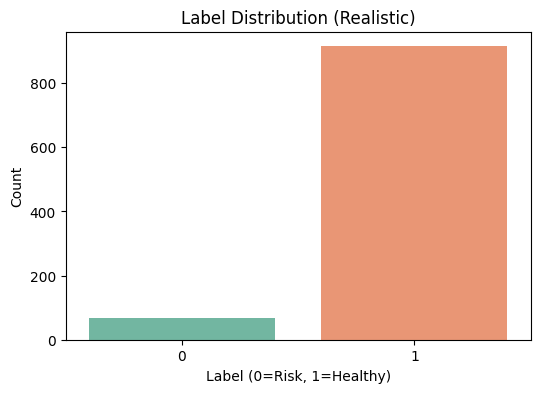

Label share by estimated income quintile:
               Risk(0)  Healthy(1)
est_quintile                      
1             0.555556    0.444444
2             0.923077    0.076923
3             1.000000    0.000000
4             1.000000    0.000000
5             0.000000    1.000000


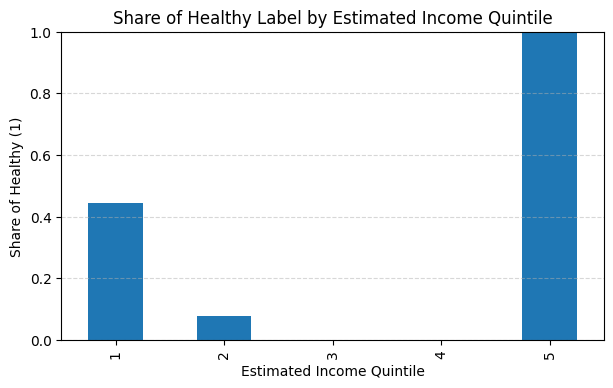

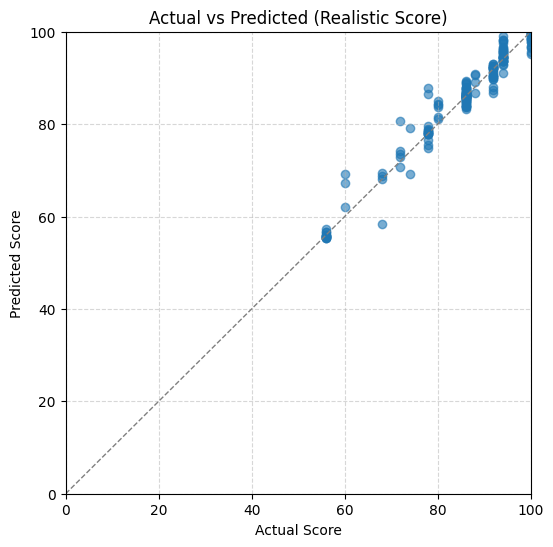

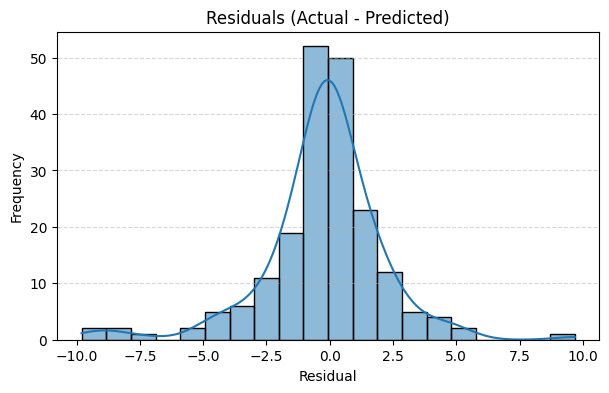

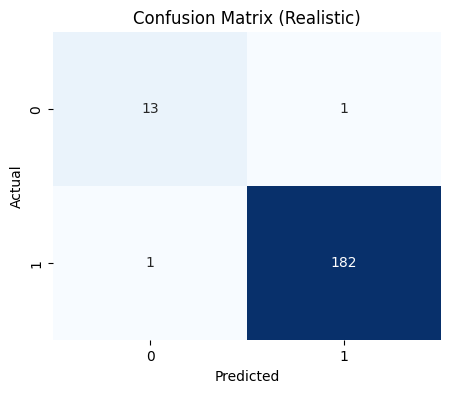

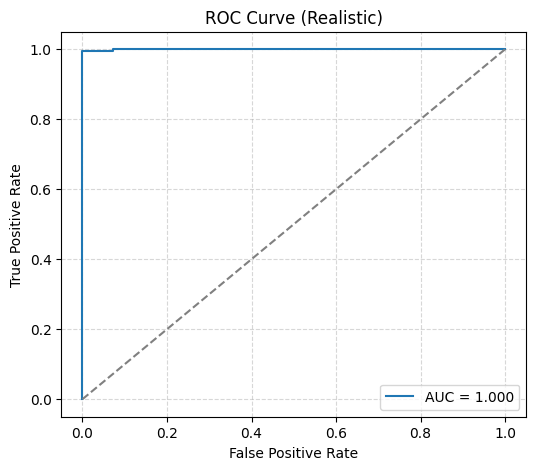

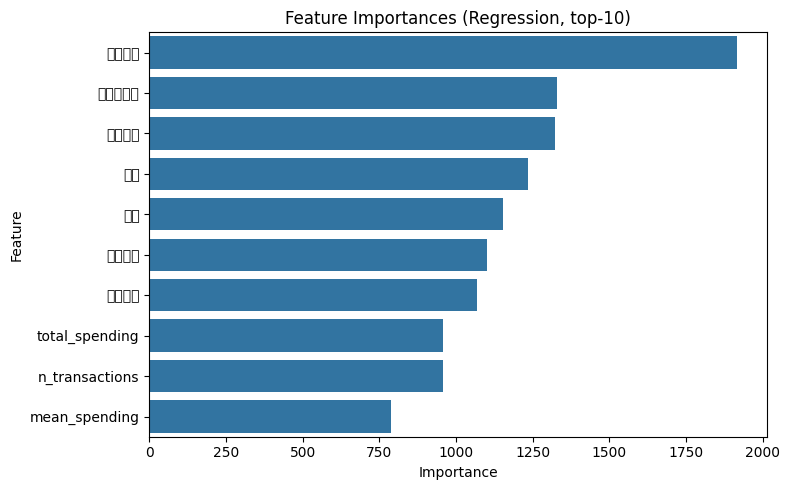

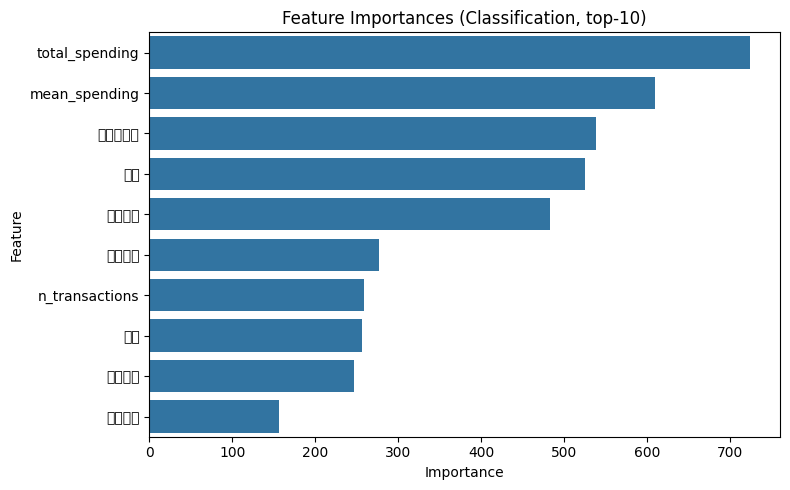


=== Realistic Model Summary ===
Label distribution: {1: 915, 0: 68}
[Regression] RMSE=2.377 | MAE=1.550 | R²=0.958
[Classification] ACC=0.990 | AUC=0.9996096799375488
Saved realistic dataset: /content/synth_finance_scored_realistic.csv


In [ ]:
# =========================================
# Plots & Diagnostics (English-only labels)
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, roc_auc_score, confusion_matrix, roc_curve
)

# 1) Label distribution
plt.figure(figsize=(6,4))
sns.countplot(x="현실형_라벨", data=df_real, palette="Set2")
plt.title("Label Distribution (Realistic)")
plt.xlabel("Label (0=Risk, 1=Healthy)")
plt.ylabel("Count")
plt.show()

# 2) Quintile-wise label rate
quintile_rate = (
    df_real.groupby("est_quintile")["현실형_라벨"]
    .value_counts(normalize=True)
    .rename("ratio")
    .reset_index()
)
pivot_rate = quintile_rate.pivot(index="est_quintile", columns="현실형_라벨", values="ratio").fillna(0)
pivot_rate.columns = ["Risk(0)", "Healthy(1)"]  # make columns explicit in English
print("Label share by estimated income quintile:")
print(pivot_rate)

plt.figure(figsize=(7,4))
pivot_rate["Healthy(1)"].plot(kind="bar")
plt.title("Share of Healthy Label by Estimated Income Quintile")
plt.xlabel("Estimated Income Quintile")
plt.ylabel("Share of Healthy (1)")
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# 3) Regression: Actual vs Predicted (Realistic score)
plt.figure(figsize=(6,6))
plt.scatter(yte_r, pr, alpha=0.6)
lims = [0, 100]
plt.plot(lims, lims, "--", color="gray", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)
plt.title("Actual vs Predicted (Realistic Score)")
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# 4) Residuals histogram
resid = yte_r - pr
plt.figure(figsize=(7,4))
sns.histplot(resid, bins=20, kde=True)
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# 5) Classification: Confusion matrix (heatmap)
pc = clf.predict(Xte)
cm = confusion_matrix(yte_c, pc)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Realistic)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 6) ROC curve
try:
    yprob = clf.predict_proba(Xte)[:, 1]
    fpr, tpr, thr = roc_curve(yte_c, yprob)
    auc = roc_auc_score(yte_c, yprob)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1], [0,1], "--", color="gray")
    plt.title("ROC Curve (Realistic)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
except Exception:
    print("ROC plot skipped (predict_proba not available).")

# 7) Feature Importances (top-10) for both models
def plot_importance(model, names, title, topn=10):
    try:
        imp = pd.Series(model.feature_importances_, index=names).sort_values(ascending=False)
        plt.figure(figsize=(8,5))
        sns.barplot(x=imp.values[:topn], y=imp.index[:topn])
        plt.title(title)
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
        return imp
    except Exception:
        print(f"{title}: feature_importances_ not available.")
        return None

feat_names = Xtr.columns
imp_reg = plot_importance(reg, feat_names, "Feature Importances (Regression, top-10)")
imp_cls = plot_importance(clf, feat_names, "Feature Importances (Classification, top-10)")

# 8) Quick summary print (matches the style you showed)
mse  = mean_squared_error(yte_r, pr)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(yte_r, pr)
r2   = r2_score(yte_r, pr)

acc = accuracy_score(yte_c, pc)
try:
    yprob = clf.predict_proba(Xte)[:, 1]
    auc = roc_auc_score(yte_c, yprob)
except Exception:
    auc = np.nan

print("\n=== Realistic Model Summary ===")
print("Label distribution:", df_real["현실형_라벨"].value_counts().to_dict())
print(f"[Regression] RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")
print(f"[Classification] ACC={acc:.3f} | AUC={auc if not np.isnan(auc) else 'NA'}")
print("Saved realistic dataset: /content/synth_finance_scored_realistic.csv")


In [ ]:
# ===============================
# Save models & feature schema
# ===============================
import joblib
import json
import os

SAVE_DIR = "/content/models"
os.makedirs(SAVE_DIR, exist_ok=True)

reg_path = os.path.join(SAVE_DIR, "realistic_regressor.pkl")
clf_path = os.path.join(SAVE_DIR, "realistic_classifier.pkl")
feat_path = os.path.join(SAVE_DIR, "feature_columns.json")

# 1) Save trained models
joblib.dump(reg, reg_path)
joblib.dump(clf, clf_path)

# 2) Save feature order used during training
feature_columns = list(X.columns)  # X = df_real[["total_spending","mean_spending","n_transactions"]+ratio_cols]
with open(feat_path, "w", encoding="utf-8") as f:
    json.dump(feature_columns, f, ensure_ascii=False, indent=2)

print("[INFO] Saved:")
print(" -", reg_path)
print(" -", clf_path)
print(" -", feat_path)

# (선택) Colab에서 바로 내려받기 원하면:
# from google.colab import files
# files.download(reg_path)
# files.download(clf_path)
# files.download(feat_path)


[INFO] Saved:
 - /content/models/realistic_regressor.pkl
 - /content/models/realistic_classifier.pkl
 - /content/models/feature_columns.json


In [ ]:
"""
로드 & 예측 예제 (단일 샘플)

입력은 학습 때와 동일한 컬럼/순서여야 합니다:
["total_spending","mean_spending","n_transactions","식료품음료","주거","교통","오락문화","교육육아","보건의료","기타소비"]
"""

In [ ]:
# ===============================
# Load & Predict (single example)
# ===============================
import numpy as np
import pandas as pd
import joblib
import json

# 1) Load
reg_loaded = joblib.load(reg_path)
clf_loaded = joblib.load(clf_path)
with open(feat_path, "r", encoding="utf-8") as f:
    feat_cols = json.load(f)

# 2) Prepare a sample row
#    - 비율 컬럼은 합계=1.0이 되도록 구성
sample = {
    "total_spending": 3200,   # 만원 가정 (연간 소비)
    "mean_spending":  20,     # 거래당 평균 소비 (만원 가정)
    "n_transactions": 420,    # 연간 거래수
    "식료품음료": 0.19,
    "주거":     0.16,
    "교통":     0.12,
    "오락문화": 0.10,
    "교육육아": 0.11,
    "보건의료": 0.12,
    "기타소비": 0.20,
}

# 정규화 안전장치
ratio_cols = ["식료품음료","주거","교통","오락문화","교육육아","보건의료","기타소비"]
s = sum(sample[c] for c in ratio_cols)

if s <= 0:
    sample["기타소비"] = 1.0
else:
    for c in ratio_cols:
        sample[c] = sample[c] / s

# 3) Build DataFrame in correct column order
x_row = pd.DataFrame([sample], columns=feat_cols)

# 4) Predict
score_pred = float(reg_loaded.predict(x_row)[0])      # 현실형_점수 예측
label_prob = getattr(clf_loaded, "predict_proba", None)
if callable(label_prob):
    prob1 = float(clf_loaded.predict_proba(x_row)[:,1][0])  # Healthy 확률
else:
    prob1 = np.nan
label_pred = int(clf_loaded.predict(x_row)[0])

print(f"[PRED] Realistic score: {score_pred:.1f}")
print(f"[PRED] Label (0/1): {label_pred} | P(Healthy=1): {prob1 if not np.isnan(prob1) else 'NA'}")


[PRED] Realistic score: 88.3
[PRED] Label (0/1): 1 | P(Healthy=1): 0.9999994490386779


In [ ]:
# ===============================
# Batch prediction on new data
# new_df: 동일 스키마의 신규 데이터프레임
# ===============================
def normalize_ratios(df, ratio_cols):
    df = df.copy()
    df[ratio_cols] = df[ratio_cols].clip(lower=0).fillna(0)
    s = df[ratio_cols].sum(axis=1)
    df.loc[s==0, "기타소비"] = 1.0
    s = df[ratio_cols].sum(axis=1)
    df[ratio_cols] = df[ratio_cols].div(s, axis=0)
    return df

# 예시: df_real의 앞 5개로 테스트
new_df = df_real[feat_cols].head(5).copy()
new_df = normalize_ratios(new_df, ratio_cols)

pred_score = reg_loaded.predict(new_df)
pred_label = clf_loaded.predict(new_df)
pred_prob  = clf_loaded.predict_proba(new_df)[:,1] if hasattr(clf_loaded,"predict_proba") else np.full(len(new_df), np.nan)

pred_out = new_df.copy()
pred_out["pred_score"] = np.round(pred_score, 1)
pred_out["pred_label"] = pred_label
pred_out["pred_prob1"] = np.round(pred_prob, 3)
print(pred_out.head())

   total_spending  mean_spending  n_transactions     식료품음료        주거  \
0    27492.492368      18.110996             460  0.159045  0.164224   
1    34150.915905      22.306281             464  0.184977  0.177204   
2    18967.762310      37.191691             155  0.190515  0.107516   
3    19115.169591      36.202973             160  0.162486  0.192536   
4     8133.653673      16.398495             150  0.193818  0.165791   

         교통      오락문화      교육육아      보건의료      기타소비  pred_score  pred_label  \
0  0.185085  0.093159  0.102484  0.137892  0.158111        94.0           1   
1  0.113835  0.096344  0.145892  0.120355  0.161393        93.7           1   
2  0.136868  0.107532  0.113083  0.141417  0.203069        86.0           1   
3  0.054145  0.097007  0.064002  0.106545  0.323279        79.8           1   
4  0.178443  0.091658  0.142158  0.151173  0.076959        87.8           1   

   pred_prob1  
0         1.0  
1         1.0  
2         1.0  
3         1.0  
4         1.